In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import scipy

In [4]:
sales_df = pd.read_csv('./sales_cleaned.csv', index_col='index')
sales_df.head()

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Day,Month_numeric
index,,,,,,,,,,,,,,,,
0,02/19/16,2016,February,29.0,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0,19,2
1,02/20/16,2016,February,29.0,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0,20,2
2,02/27/16,2016,February,29.0,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0,27,2
3,03/12/16,2016,March,29.0,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0,12,3
4,03/12/16,2016,March,29.0,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0,12,3


# Statistical tests

First, let's investigate the claim of gender having no relation with revenue generated

(2.0, 2867.3800000000047)

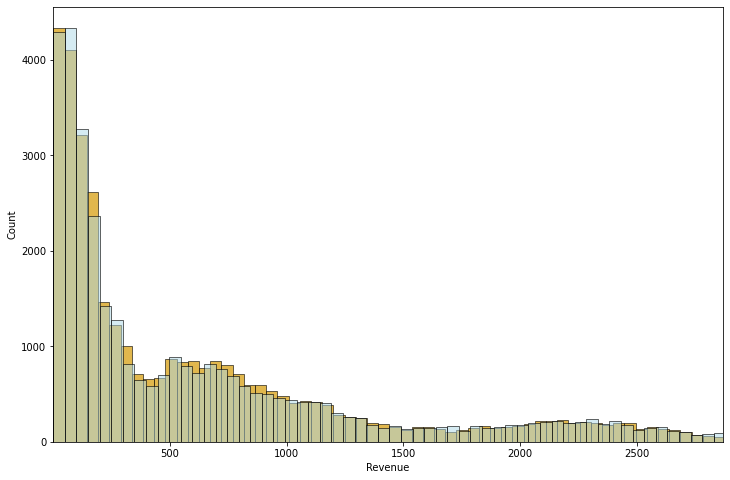

In [26]:
plt.figure(figsize = (12, 8))
sns.histplot(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, color='goldenrod', alpha = 0.8)
sns.histplot(sales_df[sales_df['Customer Gender'] == 'F'].Revenue, color='lightblue', alpha = 0.5)
plt.xlim((sales_df['Revenue'].min(), sales_df['Revenue'].quantile(0.99)))

From the figure above, we can see that the two distributions from each gender are almost identical.

However, it apperas that the distributions consist of 3 difference distribution, with a right skewed, long tail distribution (likely to be from product sales with low pricing),
and 2 gaussian mixture distributions (centered at 600 and 2200)

In [27]:
sales_df['Product Category'].unique()

array(['Accessories', 'Clothing', 'Bikes'], dtype=object)

Coincidently, it apperas that we have exactly 3 different product categories. Let's investigate if these 3 product correspond to the 3 distributions we see.

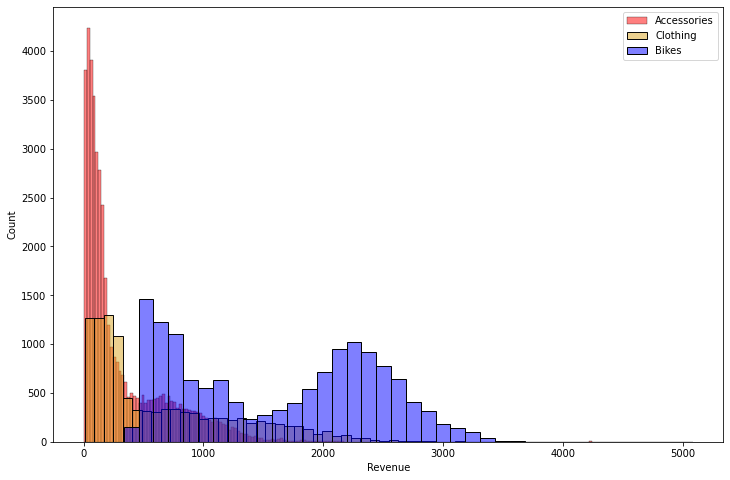

In [33]:
plt.figure(figsize=(12, 8))
for prod, color in zip(sales_df['Product Category'].unique(), ['red', 'goldenrod', 'blue']):
    sns.histplot(sales_df[sales_df['Product Category'] == prod]['Revenue'], 
    label = prod, color=color, alpha = 0.5)
plt.legend()
plt.show()

It appers that our guess was wrong, both accessories and cloting made up the right-skewed distribution, whereas the gaussian mixture distributin was from bikes category alone.

In [34]:
scipy.stats.ttest_ind(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

Ttest_indResult(statistic=0.025716200167694866, pvalue=0.9794837758535244)

Indeed, we can see that the p-value is around 0.98, which is highly unlikely that the mean of revenue spent for each gender were different.